# Non-centered data 

## Preliminaries 

In [40]:
load("non_centered.RData")

In [1]:
library(brms)
library(tidyverse)

#-------------------------------------------------------------------------------
#--- Useful functions
#-- find the root
#-------------------------------------------------------------------------------
GamF <- function(gam, p0) {
    (2 * pnorm(-abs(gam)) * exp(.5 * gam^2) - p0)^2
}

# optimize(GamF,interval = c(-30,30), p0=1 - 0.05)
GamBnd <- function(p0) {
    Re1 <- optimize(GamF, interval = c(-30, 30), p0 = 1 - p0)
    Re2 <- optimize(GamF, interval = c(-30, 30), p0 = p0)

    c(-abs(Re1$minimum), abs(Re2$minimum), Re1$objective, Re2$objective)
}
GamBnd <- Vectorize(GamBnd, "p0")

#-------------------------------------------------------------------------------
#--- Function
#-------------------------------------------------------------------------------
#--- Stan function (case 2)
tau0 <- .1


Bd <- GamBnd(tau0)[1:2]
# GAL2 <- custom_family(
#  "GAL2", dpars = c("mu", "sigma","ligam", "tau","gamL","gamU"), links=c("identity","log","identity","identity", rep("identity",2)),
#  lb=c(NA,0, -1.087,0,NA,NA), ub=c(NA,NA, 1.087,1,NA,NA), type="real") #, vars = "vint1[n]"
# GAL2 <- custom_family(
#   "GAL2", dpars = c("mu", "sigma","ligam"), links= c("identity","log","identity"),
#   lb=c(NA,0, -1.087), ub=c(NA,NA, 1.087), type="real", vars = c("tau","gamL","gamU")) #, vars = "vint1[n]"
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, -1.086, 0), ub = c(NA, NA, 1.086, 1), type = "real"
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "logit", "identity"),
    lb = c(NA, 0, -15, 0), ub = c(NA, NA, 15, 1), type = "real", vars = c("gamL", "gamU")
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau", "gamL", "gamU"), links = c("identity", "log", "identity", "identity", rep("identity", 2)),
    lb = c(NA, 0, -15, 0, NA, NA), ub = c(NA, NA, 15, 1, NA, NA), type = "real"
) # , vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .99, 0), ub = c(NA, NA, Bd[2] * .99, 1), type = "real"
) # , vars = "vint1[n]"


stan_funs2 <- "
    /*
    A = -est*p_neg + .5*pow(gam, 2)*pow(p_neg/p_pos, 2) + log(Phi_approx(a2-a3)) + log1m_exp(fabs(log(Phi_approx(a2-a3)) - log(Phi_approx(a2))));
  gam = (gamU - gamL) * ligam + gamL;
  real gam = (gamU - gamL) * ligam + gamL;
  real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau, real gamL, real gamU){
  real GAL2_rng(real mu, real sigma, real ligam, real tau, real gamL, real gamU){
   */
     /* helper function for asym_laplace_lpdf
  * Args:
    *   y: the response value
  *   tau: quantile parameter in (0, 1)
  */
    real rho_quantile(real y, real tau) {
      if (y < 0) {
        return y * (tau - 1);
      } else {
        return y * tau;
      }
    }
  /* asymmetric laplace log-PDF for a single response
  * Args:
    *   y: the response value
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau * (1 - tau)) -
        log(sigma) -
        rho_quantile((y - mu) / sigma, tau);
    }
  /* asymmetric laplace log-CDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lcdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log(tau) + (1 - tau) * (y - mu) / sigma;
      } else {
        return log1m((1 - tau) * exp(-tau * (y - mu) / sigma));
      }
    }
  /* asymmetric laplace log-CCDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lccdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log1m(tau * exp((1 - tau) * (y - mu) / sigma));
      } else {
        return log1m(tau) - tau * (y - mu) / sigma;
      }
    }

   real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau){

   real p_pos;
   real p_neg;
   real a3;
   real a2;
   real p;
   real est;
   real A;
   real B;
   real Res = 0;
   real gam = ligam;
    p = (gam < 0) + (tau - (gam < 0))/(2*Phi(-fabs(gam))*exp(.5*pow(gam, 2)));
    p_pos = p -  (gam > 0);
    p_neg = p -  (gam < 0);
    est = (y - mu) / sigma;

    if(fabs(gam) > 0){
    a3 = p_pos * (est / fabs(gam));
    a2 = fabs(gam) * (p_neg / p_pos);


    if(est/gam > 0){
      A =  0.5*pow(gam, 2)*pow(p_neg/p_pos, 2) - est*p_neg + log_diff_exp(log(Phi_approx(a2-a3)), log(Phi_approx(a2)) );
      B =  0.5*pow(gam, 2) - p_pos*est + log(Phi_approx(-fabs(gam) + a3));
      Res = log(2*p*(1-p)) - log(sigma) +  log_sum_exp(A, B);
    }else{
      Res =  log(2*p*(1-p)) - log(sigma) - p_pos * est + 0.5 * pow(gam, 2) + log(Phi_approx(-fabs(gam) ));
    }
    }else{
    Res = asym_laplace_lpdf( y | mu, sigma, tau);
    }

    return Res;
   }

  real GAL2_rng(real mu, real sigma, real ligam, real tau){

     real A;
     real B;
     real C;
     real p;
     real hi;
     real nui;
     real mui=0;
     real Up = uniform_rng(.5, 1.0);

     real gam = ligam;
     p = (gam < 0) + (tau - (gam < 0))/(2*Phi_approx(-fabs(gam))*exp(.5*pow(gam, 2)));
     A = (1 - 2*p)/(p - pow(p,2));
     B = 2/(p - pow(p,2));
     C = 1/((gam > 0) - p);

      hi = sigma * inv_Phi(Up);
     nui = sigma * exponential_rng(1);
     mui += mu + A * nui + C * fabs(gam) * hi;

     return normal_rng(mui, sqrt(sigma*B*nui));
  }
  "


#--- Now define all of these here
# stanvars <- stanvar(scode = stan_funs, block = "functions")
stanvars2 <- stanvar(scode = stan_funs2, block = "functions")

# priorval = c(prior(normal(0, 15), class = "Intercept"),
#           # Prior guess of 80% of the terms are non-zero
#           prior(horseshoe(par_ratio =0.8), class = "b"))

#--- Fit the quantile regression
#-- quantile

# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace(), prior = set_prior(horseshoe(df=1,par_ratio = 0.1), class="b"))
# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace())

# fit_fakeqGal.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL,
#                             stanvars = stanvars,chains = 3,iter = 10000, control = list(adapt_delta = 0.97, max_treedepth = 10))


# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 3,iter = 1000)
# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5,gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 2000, init = 0.1, control = list(adapt_delta = 0.97))

# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.9 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.1 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,


Loading required package: Rcpp

Loading 'brms' package (version 2.18.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Linear mean

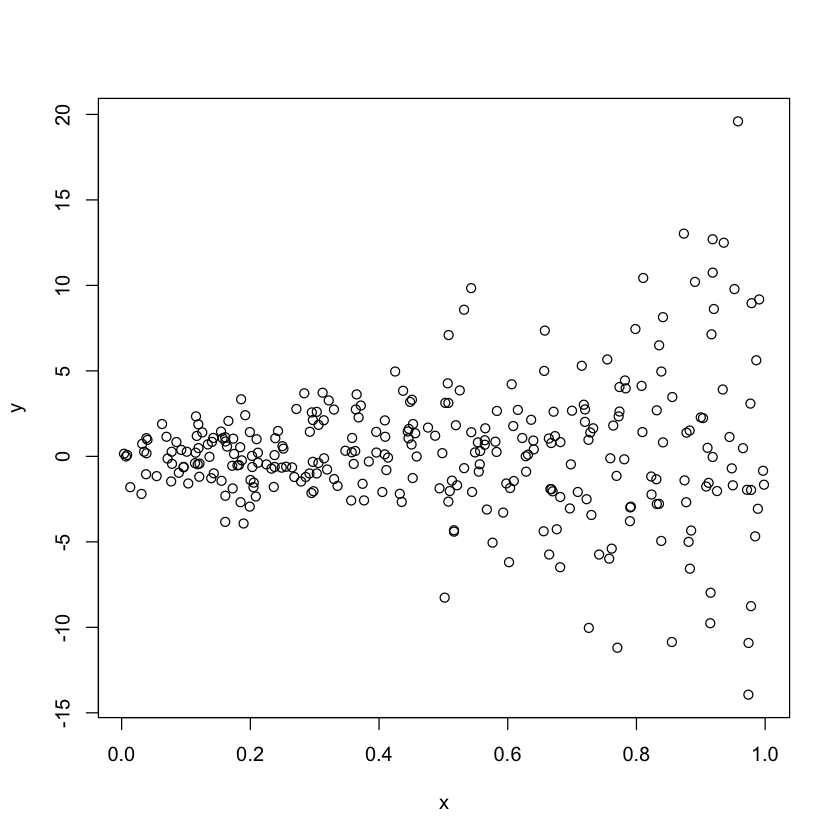

In [7]:
N <- 300
x <- runif(N, 0, 1)
y <- rnorm(N, mean = x, sd = exp(2*x))

synthetic <- data.frame(x = x, y = y)
plot(x, y)

In [8]:
Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, 
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [9]:
summary(q25)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ s(x) 
         sigma ~ s(x)
         tau = 0.25
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smooth Terms: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sx_1)           1.36      1.16     0.06     4.44 1.01      840     1062
sds(sigma_sx_1)     0.52      0.52     0.02     1.92 1.00      731     1231

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -1.66      0.22    -2.09    -1.26 1.00     2962     1358
sigma_Intercept    -0.13      0.10    -0.34     0.05 1.00     1400     1775
sx_1               -4.43      3.72   -12.26     3.27 1.00     1051      829
sigma_sx_1          3.66      1.37     0.92     6.78 1.00      882      876

Family Specific Parameters: 
      Estimate

In [13]:
# install.packages("altair")
# library(altair)
# library(reticulate)
# reticulate::use_condaenv("r-reticulate")
# altair::install_altair()

Warning message in reticulate::use_condaenv("r-reticulate"):
“multiple Conda environments found; the first-listed will be chosen.
          name
2 r-reticulate
7 r-reticulate
                                                                 python
2 /Users/nescoba/Library/r-miniconda-arm64/envs/r-reticulate/bin/python
7             /Users/nescoba/opt/anaconda3/envs/r-reticulate/bin/python”


Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


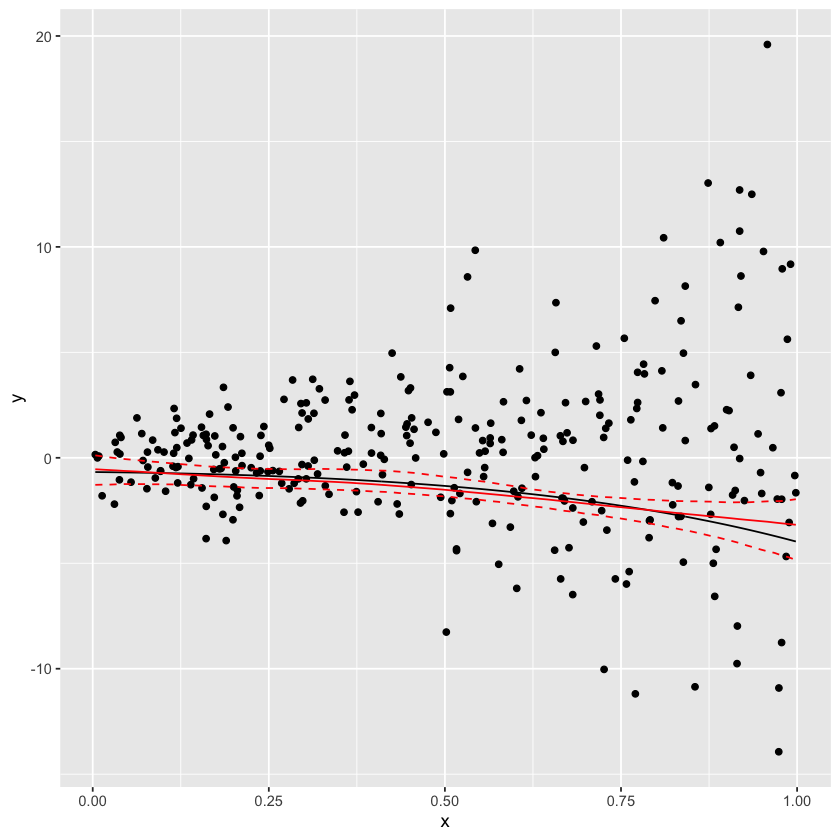

In [22]:
library(ggplot2)

csq25 <- conditional_smooths(q25)
csq25df <- csq25[[1]]

# Add the theoretical quantiles to the synthetic data
synthetic$yq25 <- qnorm(.25, mean = synthetic$x, sd = exp(2*synthetic$x))
synthetic$yq50 <- qnorm(.5, mean = synthetic$x, sd = exp(2*synthetic$x))
synthetic$yq75 <- qnorm(.75, mean = synthetic$x, sd = exp(2*synthetic$x))
synthetic$yq90 <- qnorm(.9, mean = synthetic$x, sd = exp(2*synthetic$x))

b <- summary(q25)$fixed["Intercept", "Estimate"]

# Draw a scatterplot of the data in the synthetic data frame using ggplot 
# add a solid black line for the yq25 column 
# add a layer that takes the csq25df data frame and draws 
# a solid red line for the estimate__ column, 
# a dashed red line for the lower__ column,
# and a dashed red line for the upper__ column
ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq25), color = "black") +
  geom_line(data = csq25df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq25df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq25df, aes(y = b + upper__), linetype = "dashed", color = "red")


In [24]:
Bd <- GamBnd(.5)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q50 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .5), data = synthetic, family = GAL2, stanvars = stanvars2, 
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)


Compiling Stan program...

Start sampling

Warning message:
“There were 1834 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 5 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating 

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 1834 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


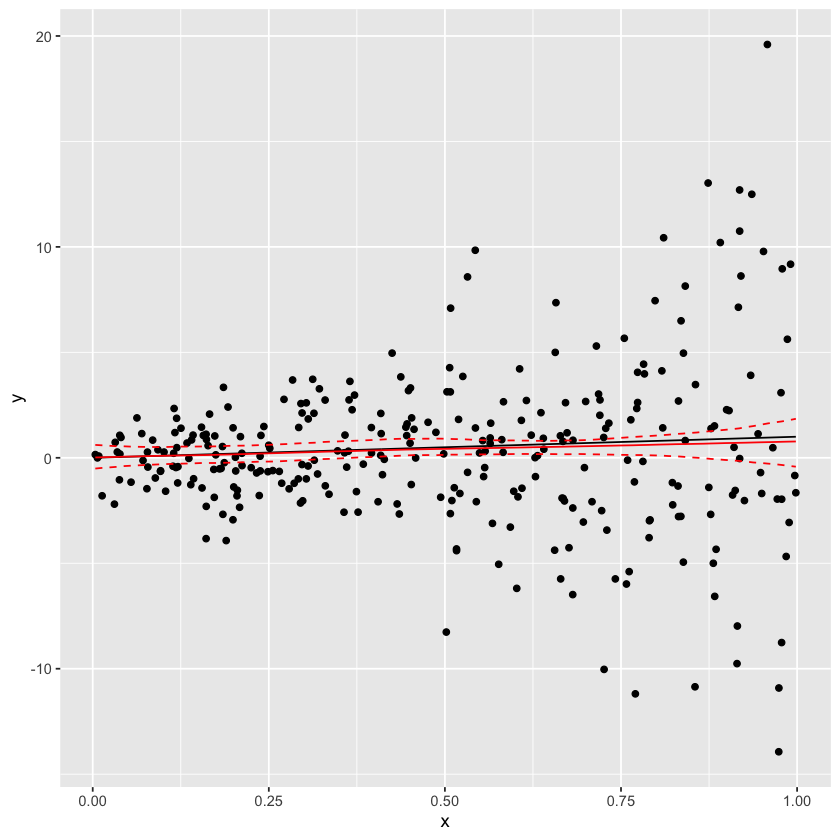

In [25]:
csq50 <- conditional_smooths(q50)
csq50df <- csq50[[1]]

b <- summary(q50)$fixed["Intercept", "Estimate"]

ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq50), color = "black") +
  geom_line(data = csq50df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq50df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq50df, aes(y = b + upper__), linetype = "dashed", color = "red")

In [26]:
Bd <- GamBnd(.75)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q75 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .75), data = synthetic, family = GAL2, stanvars = stanvars2,
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)


Compiling Stan program...

Start sampling



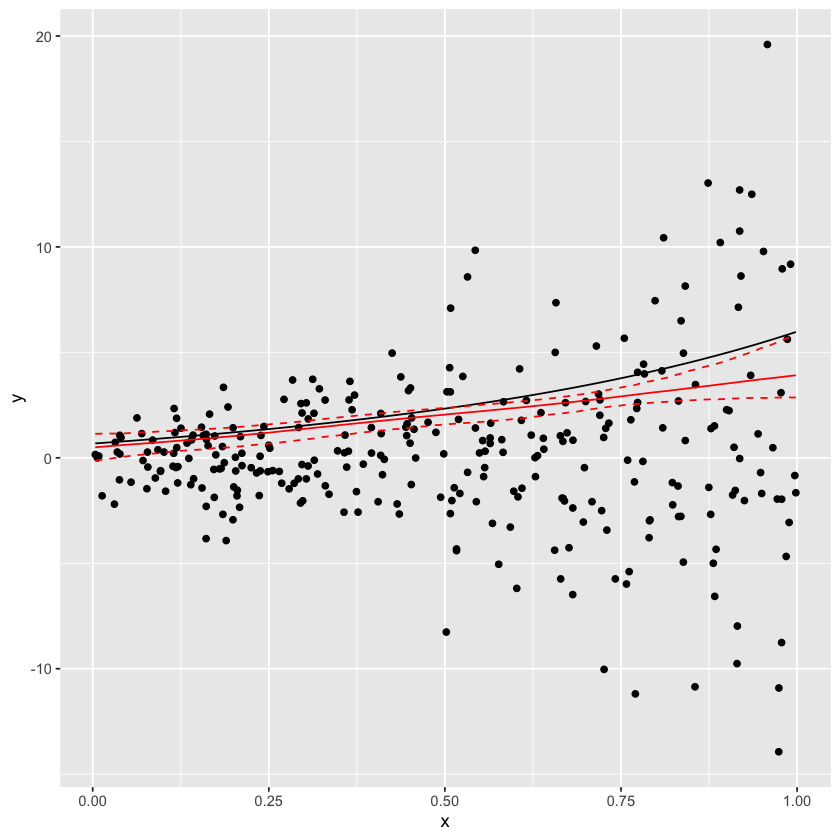

In [27]:
csq75 <- conditional_smooths(q75)
csq75df <- csq75[[1]]

b <- summary(q75)$fixed["Intercept", "Estimate"]

ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq75), color = "black") +
  geom_line(data = csq75df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq75df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq75df, aes(y = b + upper__), linetype = "dashed", color = "red")

In [28]:
Bd <- GamBnd(.9)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q90 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .9), data = synthetic, family = GAL2, stanvars = stanvars2,
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling



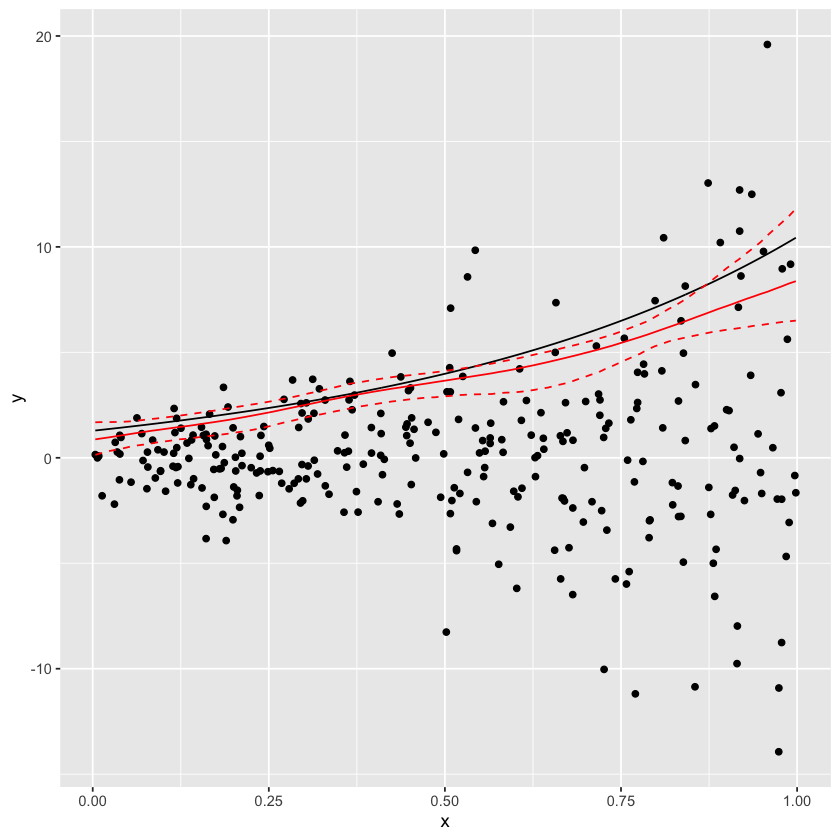

In [29]:
csq90 <- conditional_smooths(q90)
csq90df <- csq90[[1]]

b <- summary(q90)$fixed["Intercept", "Estimate"]

ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq90), color = "black") +
  geom_line(data = csq90df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq90df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq90df, aes(y = b + upper__), linetype = "dashed", color = "red")

## Quadratic mean

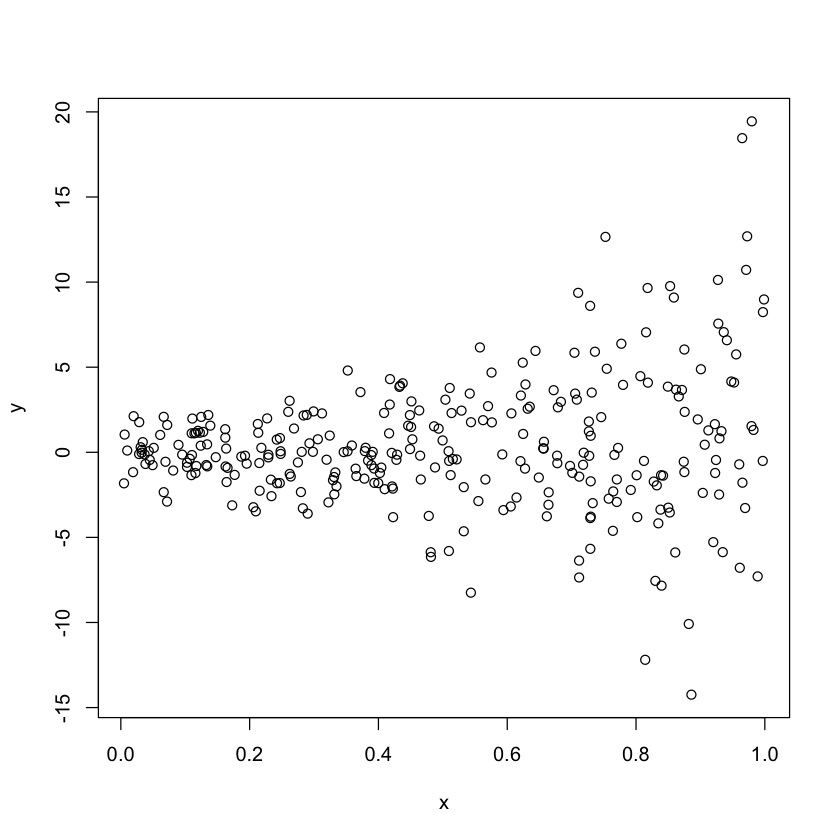

In [30]:
N <- 300
x <- runif(N, 0, 1)
y <- rnorm(N, mean = x^2, sd = exp(2*x))

synthetic <- data.frame(x = x, y = y)
plot(x, y)

In [31]:
Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, 
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling



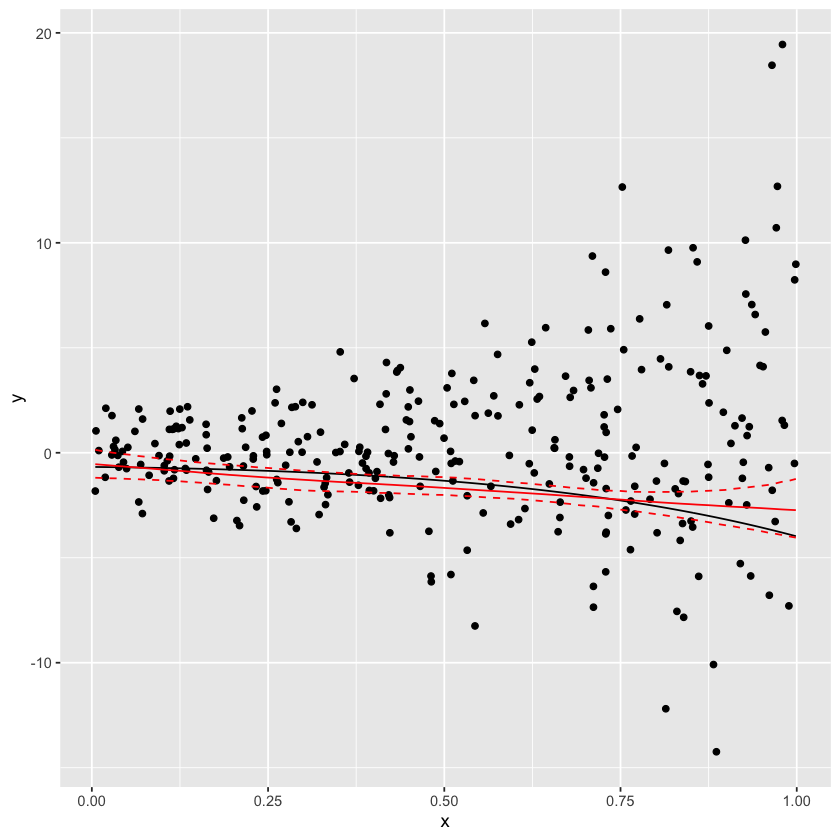

In [32]:
csq25 <- conditional_smooths(q25)
csq25df <- csq25[[1]]

# Add the theoretical quantiles to the synthetic data
synthetic$yq25 <- qnorm(.25, mean = synthetic$x, sd = exp(2*synthetic$x))
synthetic$yq50 <- qnorm(.5, mean = synthetic$x, sd = exp(2*synthetic$x))
synthetic$yq75 <- qnorm(.75, mean = synthetic$x, sd = exp(2*synthetic$x))
synthetic$yq90 <- qnorm(.9, mean = synthetic$x, sd = exp(2*synthetic$x))

b <- summary(q25)$fixed["Intercept", "Estimate"]

# Draw a scatterplot of the data in the synthetic data frame using ggplot 
# add a solid black line for the yq25 column 
# add a layer that takes the csq25df data frame and draws 
# a solid red line for the estimate__ column, 
# a dashed red line for the lower__ column,
# and a dashed red line for the upper__ column
ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq25), color = "black") +
  geom_line(data = csq25df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq25df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq25df, aes(y = b + upper__), linetype = "dashed", color = "red")


In [33]:
Bd <- GamBnd(.5)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q50 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .5), data = synthetic, family = GAL2, stanvars = stanvars2, 
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)


Compiling Stan program...

Start sampling

Warning message:
“There were 1705 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 295 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicatin

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 1705 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


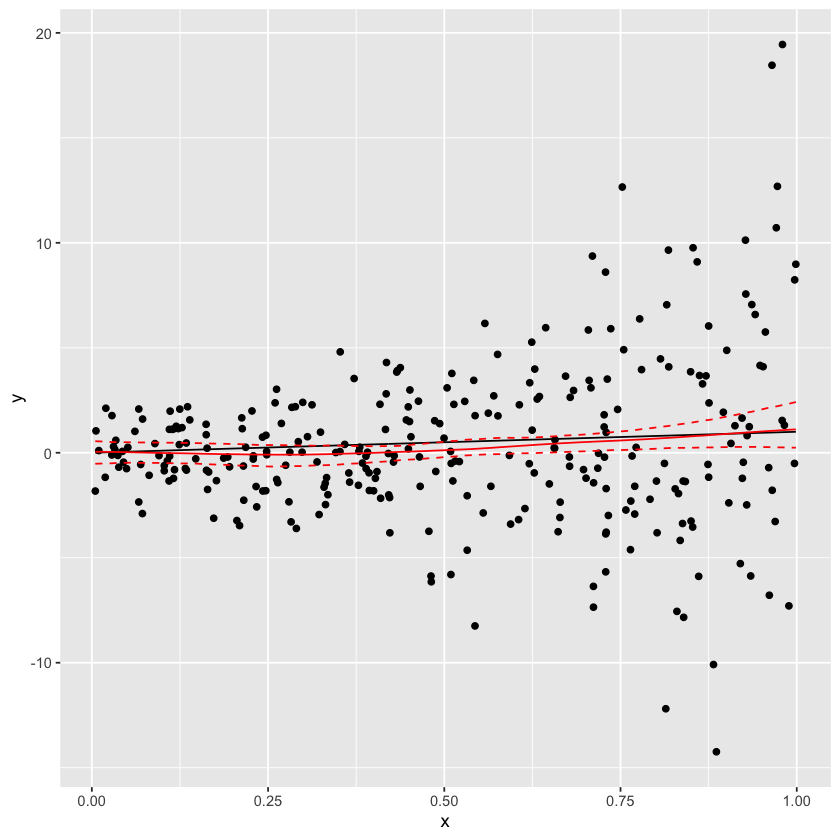

In [34]:
csq50 <- conditional_smooths(q50)
csq50df <- csq50[[1]]

b <- summary(q50)$fixed["Intercept", "Estimate"]

ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq50), color = "black") +
  geom_line(data = csq50df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq50df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq50df, aes(y = b + upper__), linetype = "dashed", color = "red")

In [35]:
Bd <- GamBnd(.75)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q75 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .75), data = synthetic, family = GAL2, stanvars = stanvars2,
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)


Compiling Stan program...

Start sampling



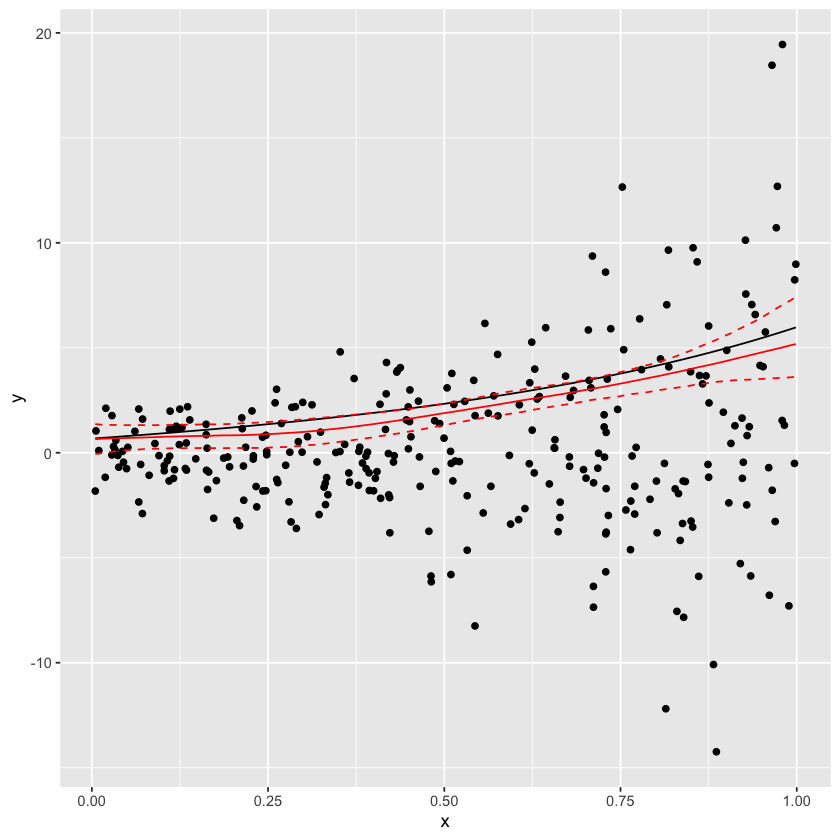

In [36]:
csq75 <- conditional_smooths(q75)
csq75df <- csq75[[1]]

b <- summary(q75)$fixed["Intercept", "Estimate"]

ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq75), color = "black") +
  geom_line(data = csq75df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq75df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq75df, aes(y = b + upper__), linetype = "dashed", color = "red")

In [37]:
Bd <- GamBnd(.9)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q90 <- brm(bf(y ~ s(x), sigma ~ s(x), tau = .9), data = synthetic, family = GAL2, stanvars = stanvars2,
chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling



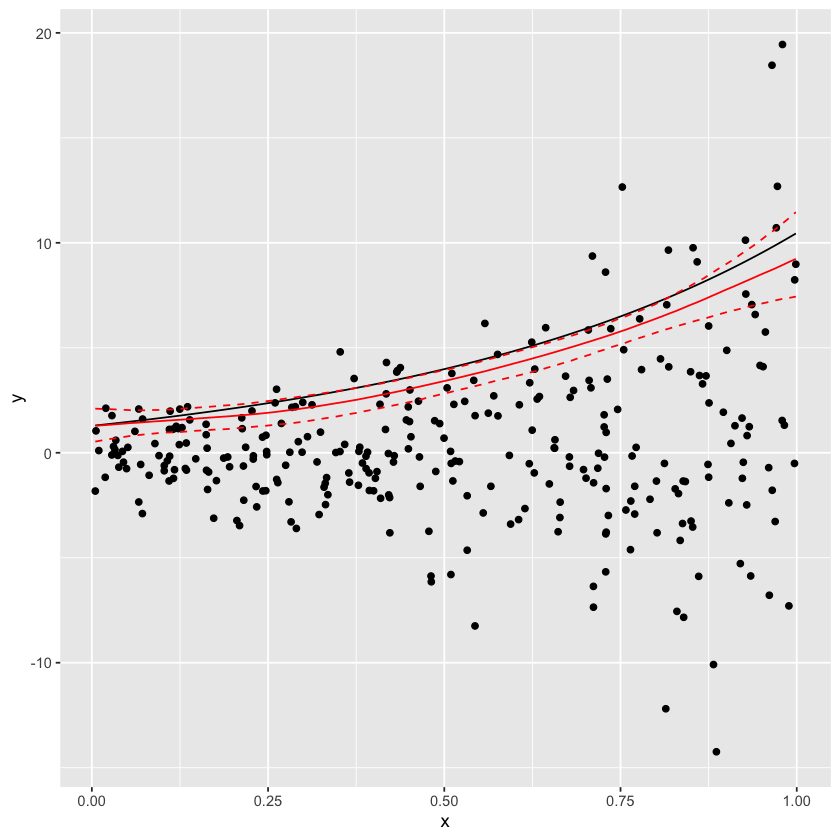

In [38]:
csq90 <- conditional_smooths(q90)
csq90df <- csq90[[1]]

b <- summary(q90)$fixed["Intercept", "Estimate"]

ggplot(synthetic, aes(x = x, y = y)) +
  geom_point() +
  geom_line(aes(y = yq90), color = "black") +
  geom_line(data = csq90df, aes(y = b + estimate__), color = "red") +
  geom_line(data = csq90df, aes(y = b + lower__), linetype = "dashed", color = "red") +
  geom_line(data = csq90df, aes(y = b + upper__), linetype = "dashed", color = "red")

In [39]:
save(file = "non_centered.RData", list = ls())